In this notebook, I plotted the pre- and post-event distributions for all biomarkers, for normal, non-normal, and sigmoid model. 

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('../sample_data/j500_r0.25_ExiNearNormalWithNoise_kjContinuousBeta_m0.csv')
df.head()

,participant,biomarker,measurement,diseased,event_time,k_j,affected
0,0,FUS-FCI,22.151560,True,4.190635,8.256794,True
1,0,P-Tau,24.364546,True,7.501504,8.256794,True
2,0,MMSE,27.815532,True,9.320614,8.256794,False
3,0,AB,272.528129,True,8.860357,8.256794,False
4,0,HIP-FCI,-16.535047,True,1.457086,8.256794,True


In [27]:
from pysaebm.utils.generate_data import very_irregular_distribution
from pysaebm import get_params_path
import json 

def generate_irregular_samples(biomarker_params, biomarker, state):
    return very_irregular_distribution(
        biomarker=biomarker,
        bm_params=biomarker_params[biomarker],
        state=state,
        size=100000
    )

params_file = get_params_path()
with open(params_file, 'r') as f:
    biomarker_params = json.load(f)


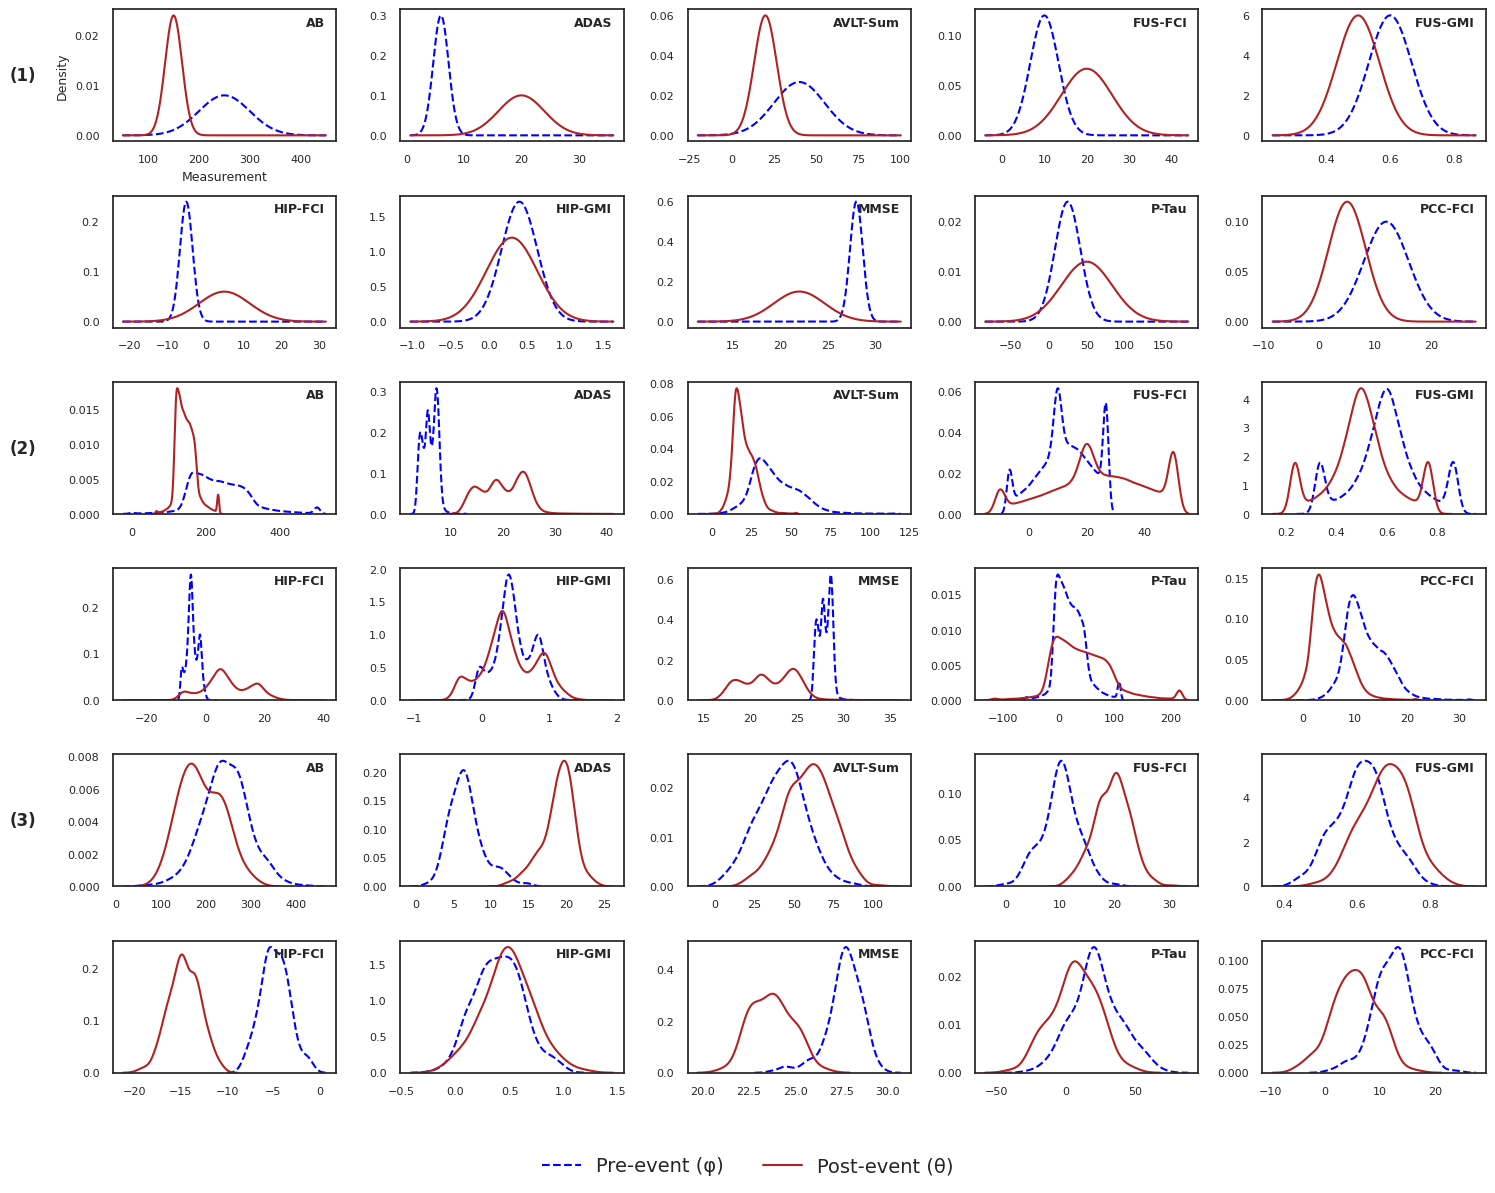

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm


# --- Styling ---
sns.set(style="white")
plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.titlesize": 12
})

# --- Setup ---
biomarkers = sorted(biomarker_params.keys())
n_rows, n_cols = 2, 5
fig, axs = plt.subplots(3 * n_rows, n_cols, figsize=(n_cols * 3, 3 * n_rows * 2))
axs = axs.reshape(3, n_rows * n_cols)

# --- Plot (1) Theoretical Normal ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[0, idx]
    params = biomarker_params[biomarker]
    lo = min(params["phi_mean"] - 4 * params["phi_std"], params["theta_mean"] - 4 * params["theta_std"])
    hi = max(params["phi_mean"] + 4 * params["phi_std"], params["theta_mean"] + 4 * params["theta_std"])
    xs = np.linspace(lo, hi, 200)
    ax.plot(xs, norm.pdf(xs, params["phi_mean"], params["phi_std"]), "--", color="blue", label="Pre-event (φ)")
    ax.plot(xs, norm.pdf(xs, params["theta_mean"], params["theta_std"]), "-", color="firebrick", label="Post-event (θ)")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    if idx == 0:
        ax.set_xlabel("Measurement", fontweight="normal")
        ax.set_ylabel("Density", fontweight="normal")
    else:
        ax.set_xlabel("")
        ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=8)

# --- Plot (2) Irregular ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[1, idx]
    pre = generate_irregular_samples(biomarker_params, biomarker, "nonaffected")
    post = generate_irregular_samples(biomarker_params, biomarker, "affected")
    sns.kdeplot(pre, ax=ax, linestyle="--", color="blue")
    sns.kdeplot(post, ax=ax, linestyle="-", color="firebrick")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=8)

# --- Plot (3) Empirical KDE ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[2, idx]
    subset = df[df["biomarker"] == biomarker].dropna(subset=["measurement", "affected"])
    subset["affected"] = subset["affected"].astype(bool)
    pre = subset[subset["affected"] == False]["measurement"]
    post = subset[subset["affected"] == True]["measurement"]
    if len(pre) >= 2:
        sns.kdeplot(pre, ax=ax, linestyle="--", color="blue")
    if len(post) >= 2:
        sns.kdeplot(post, ax=ax, linestyle="-", color="firebrick")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=8)

# --- Update row labels ---
for row_idx, label in enumerate(["(1)", "(2)", "(3)"]):
    axs[row_idx, 0].text(-0.4, 0.5, label, transform=axs[row_idx, 0].transAxes,
                         fontsize=12, fontweight='bold', va='center', ha='center')

# --- Legend ---
handles, labels = axs[0, 0].get_legend_handles_labels()
for row in axs:
    for ax in row:
        legend = ax.get_legend()
        if legend:
            legend.remove()

fig.tight_layout(pad=1.0)
fig.subplots_adjust(bottom=0.1)
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=14)

plt.show()

In [29]:
# Optional: Save figure
fig.savefig("all_distributions.pdf", bbox_inches="tight")